In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(vegan)
library(dplyr)
library(ggplot2)
library(rwantshue)

Loading required package: permute
Loading required package: lattice
This is vegan 2.3-0

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
%%R
#install.packages("dplyr")

NULL


In [4]:
%%R
physeq = import_biom("../../SeqData/ITS.otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)

In [5]:
%%R
md = sample_data(physeq)

In [6]:
%%R
otu_tab = otu_table(physeq) %>% data.frame

In [7]:
%%R
colnames(otu_tab) = colnames(otu_table(physeq))

In [8]:
from cogent.maths.stats.rarefaction import rarefaction
import pandas.rpy.common as com
from numpy import vstack, arange, mean
import pandas as pd

/opt/virt_env/lib/python2.7/site-packages/pandas/rpy/__init__.py:11: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  FutureWarning)


In [9]:
def get_raref_vector(data, stride=10, iters=25):
    rare_data = vstack([[len(h.nonzero()[0]) for h in rarefaction(data, stride=stride)] \
                        for i in range(iters)])
    X = arange(stride,data.sum()+stride,stride)
    return X, mean(rare_data, axis=0)

In [10]:
otu_tab = com.load_data("otu_tab")

In [11]:
%%time
# This takes a few minutes
dfs = {}
for sid in otu_tab.columns:
    counts = otu_tab[sid]
    x, raref_data = get_raref_vector(counts, iters=10)
    dfs[sid] = pd.DataFrame(data={"x" : x, "y" : raref_data})  

CPU times: user 42.8 s, sys: 115 ms, total: 43 s
Wall time: 43.3 s


In [12]:
d = pd.concat(dfs, axis=0)
d.reset_index(inplace=True)
d.drop(["level_1"], axis=1, inplace=True)
d.rename(columns={"level_0" : "SampleID"}, inplace=True)
d.head()

,SampleID,x,y
0,1,10,9.0
1,1,20,14.9
2,1,30,19.4
3,1,40,23.9
4,1,50,28.0


In [13]:
d = com.convert_to_r_dataframe(d, strings_as_factors=True)
%Rpush d

In [14]:
%%R
d<-data.frame(d)

In [15]:
%%R
md = sample_data(physeq) %>% data.frame %>% add_rownames("SampleID")

In [16]:
%%R
head(md)

Source: local data frame [6 x 10]

  SampleID         DNA Description OrigBarcodes Cosm BarcodeSequence Month
1       61 0.522110535  MineralITS TTCTGGTCTTGT   49    ACAAGACCAGAA   2.5
2        7 2.106005412  MineralITS CATGTCTTCCAT   22    ATGGAAGACATG     3
3       96 18.32517293  MineralITS GAACACTTTGGA   49    TCCAAAGTGTTC   2.5
4       56 4.390171111  MineralITS GACTCTGCTCAG   44    CTGAGCAGAGTC     3
5       93 21.30301639  MineralITS GTAGATCGTGTA   14    TACACGATCTAC   2.5
6       55 0.909940566  MineralITS TGGTTCATCCTT   44    AAGGATGAACCA     3
Variables not shown: LinkerPrimerSequence (chr), Trtmt (chr), Buff (chr)


Joining by: "SampleID"
geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


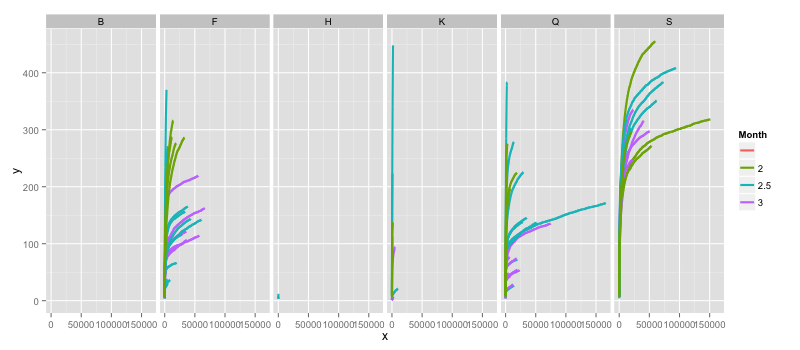

In [17]:
%%R -w 800 -h 350
d.plot = d %>% 
    left_join(md)

p = ggplot(d.plot, aes(x = x, y = y, group = SampleID, color = Month))

p = p + facet_grid(. ~ Trtmt)

p = p + geom_line(size = 1)

p   

Joining by: "SampleID"
geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


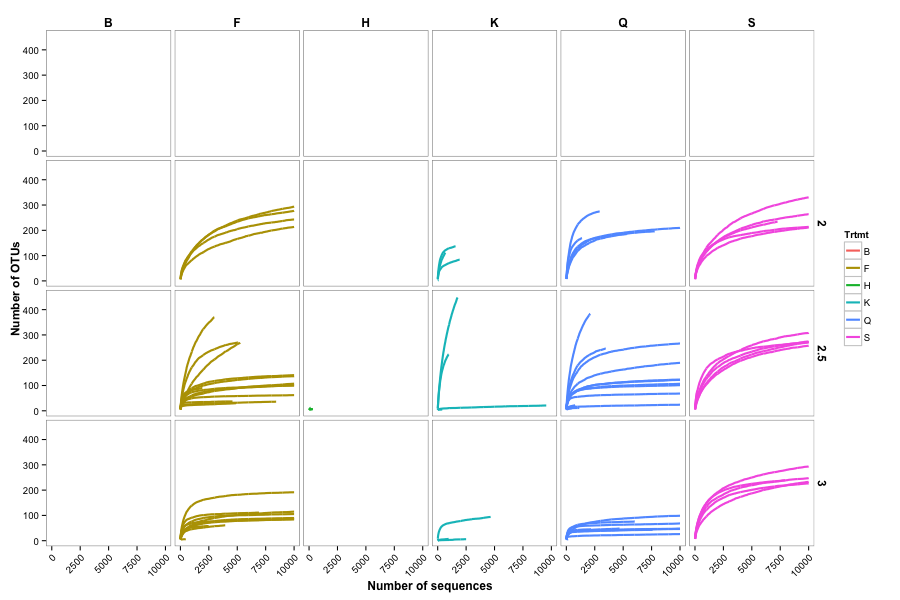

In [27]:
%%R -w 900 -h 600

d.plot = d %>% 
    left_join(md)


scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Trtmt)), color_space = hcl_presets$pastel)


p = ggplot(d.plot, aes(x = x, y = y, group = SampleID, color = Trtmt))

p = p + facet_grid(Month ~ Trtmt)

p = p + geom_line(size = 1)

#p = p + labs(colour = "Substrate")


p = p + ylab("Number of OTUs") + xlab("Number of sequences") + xlim(0,10000)
#+ xlim(0,2000) + ylim(0,1000)

p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  )

p = p + scale_fill_manual(values = colors)

p = p + theme(axis.text.x=element_text(angle = 45, hjust = 1))

p = p + theme(axis.title.x = element_text(size=12, face="bold")
             ,axis.title.y = element_text(size=12, face="bold"))

p = p + theme(strip.text = element_text(size=12, face="bold"),
        strip.background = element_rect(colour="white", fill="white"))

p = p + theme(strip.text.x = element_text(size=12, face="bold"),
        strip.background = element_rect(colour="white", fill="white"))


p   